# From experiments 1, 2 and 3

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from model import InceptionFeatureExtractor

import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [6]:
image_w = 1920
image_h = 1080
dummy_img = torch.zeros(1, 3, image_h, image_w).float()

feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

# Experiment 4

In [5]:
import torch
from torchvision.ops import box_iou, box_convert, nms

def generate_base_anchors(scales, aspect_ratios, down_h, down_w):
    ctr_y, ctr_x = down_h/2.0, down_w/2.0
    A = len(scales) * len(aspect_ratios)
    base = np.zeros((A,4), dtype=np.float32)
    idx = 0
    for s in scales:
        for ar in aspect_ratios:
            h = down_h * s * np.sqrt(ar)
            w = down_w * s * np.sqrt(1/ar)
            base[idx,0] = ctr_y - h/2.0  # y_min
            base[idx,1] = ctr_x - w/2.0  # x_min
            base[idx,2] = ctr_y + h/2.0  # y_max
            base[idx,3] = ctr_x + w/2.0  # x_max
            idx += 1
    return base

def generate_anchor_boxes(fmap_size, base_anchors, down_h, down_w):
    Hf, Wf = fmap_size
    shift_y = np.arange(0, Hf) * down_h
    shift_x = np.arange(0, Wf) * down_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.stack([shift_y.ravel(), shift_x.ravel(),
                       shift_y.ravel(), shift_x.ravel()], axis=1)
    K = shifts.shape[0]; A = base_anchors.shape[0]
    all_ = base_anchors.reshape((1,A,4)) + shifts.reshape((K,1,4))
    return all_.reshape((K*A,4))

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    """
    Projects boxes between activation‐map coords and pixel/image coords.
    
    Inputs:
      bboxes              Tensor[B, ..., 4] in [ymin, xmin, ymax, xmax] (padded boxes == -1)
      width_scale_factor  float or Tensor broadcastable to bboxes[...,0]
      height_scale_factor float or Tensor broadcastable to bboxes[...,0]
      mode                'a2p' (activation→pixel) or 'p2a' (pixel→activation)
    
    Returns:
      Tensor of same shape as `bboxes`
    """
    assert mode in ['a2p','p2a']
    B = bboxes.size(0)
    # flatten all but batch
    flat = bboxes.clone().view(B, -1, 4)
    mask = (flat == -1)  # remember padded entries

    if mode == 'a2p':
        # y dims [0,2] scale by height, x dims [1,3] by width
        flat[:,:, [0,2]] *= height_scale_factor
        flat[:,:, [1,3]] *= width_scale_factor
    else:
        flat[:,:, [0,2]] /= height_scale_factor
        flat[:,:, [1,3]] /= width_scale_factor

    # restore padding
    flat[mask] = -1
    return flat.view_as(bboxes)


def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):
    """
    Compute IoU between every anchor and every GT box in each image.
    
    Inputs:
      batch_size      int B
      anc_boxes_all   Tensor[B, H, W, A, 4] in [ymin, xmin, ymax, xmax]
      gt_bboxes_all   Tensor[B, N, 4] (pad boxes = -1)
    
    Returns:
      Tensor[B, H*W*A, N] of IoU values (invalid GT boxes → IoU=0)
    """
    device = anc_boxes_all.device
    # flatten anchors to (B, M, 4)
    anc_flat = anc_boxes_all.view(batch_size, -1, 4)
    M = anc_flat.size(1)
    N = gt_bboxes_all.size(1)

    ious = torch.zeros((batch_size, M, N), device=device)
    for b in range(batch_size):
        anc = anc_flat[b]               # (M,4)
        gt  = gt_bboxes_all[b]         # (N,4)
        # mask out padded GT.
        valid = (gt[:,0] >= 0)
        if valid.any():
            gt_valid = gt[valid]
            iou_b   = box_iou(anc, gt_valid)  # (M, num_valid)
            # write back only into the valid columns
            ious[b,:,valid] = iou_b
    return ious


def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    """
    Given matched positive anchors and GTs (both xyxy),
    compute Faster‑RCNN regression targets (tx,ty,tw,th).
    
    Inputs:
      pos_anc_coords   Tensor[P,4] in xyxy
      gt_bbox_mapping  Tensor[P,4] in xyxy
    
    Returns:
      Tensor[P,4] of targets
    """
    # convert to cxcywh
    anc_cxywh = box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_cxywh  = box_convert(gt_bbox_mapping,  in_fmt='xyxy', out_fmt='cxcywh')

    anc_cx, anc_cy, anc_w, anc_h = anc_cxywh.unbind(dim=1)
    gt_cx,  gt_cy,  gt_w,  gt_h    = gt_cxywh.unbind(dim=1)

    tx = (gt_cx - anc_cx) / anc_w
    ty = (gt_cy - anc_cy) / anc_h
    tw = torch.log(gt_w  / anc_w)
    th = torch.log(gt_h  / anc_h)

    return torch.stack([tx, ty, tw, th], dim=1)


def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all,
                    pos_thresh=0.7, neg_thresh=0.2):
    """
    Prepare positive/negative anchor indices and targets for RPN training.
    
    Returns:
      positive_inds, negative_inds,
      GT_conf_scores, GT_offsets, GT_class_pos,
      pos_coords, neg_coords,
      pos_inds_per_image
    """
    B, H, W, A, _ = anc_boxes_all.shape
    M = H * W * A
    N = gt_bboxes_all.size(1)

    # 1) IoU matrix [B, M, N]
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)

    # 2) For each GT find its best anchor → force positive
    max_iou_per_gt, _ = iou_mat.max(dim=1, keepdim=True)  # [B,1,N]
    pos_mask = (iou_mat == max_iou_per_gt) & (max_iou_per_gt > 0)
    # also any anchor > pos_thresh
    pos_mask |= (iou_mat > pos_thresh)

    # 3) flatten (B,M) → total_anchors and grab positive indices
    pos_mask_flat = pos_mask.view(-1, N)      # [(B*M), N]
    pos_any       = pos_mask_flat.any(dim=1)  # [(B*M)]
    positive_inds = torch.where(pos_any)[0]

    # keep per-image positive inds if needed
    # e.g. pos_inds_per_image = torch.where(pos_mask.view(B, M, N).any(-1))

    # 4) get conf scores for positive anchors
    # IoU of each anchor with its best GT
    max_iou_per_anchor, anchor_to_gt = iou_mat.max(dim=2)  # [B, M]
    conf_scores = max_iou_per_anchor.view(-1)[positive_inds]

    # 5) get class targets
    # expand classes & gather
    cls_expand = gt_classes_all.unsqueeze(1).expand(B, M, N)
    class_map = torch.gather(cls_expand, 2, anchor_to_gt.unsqueeze(-1)).squeeze(-1)
    class_map = class_map.view(-1)
    GT_class_pos = class_map[positive_inds]

    # 6) get GT box coords for positive anchors
    bboxes_expand = gt_bboxes_all.unsqueeze(1).expand(B, M, N, 4)
    gt_box_for_anchor = torch.gather(
        bboxes_expand,
        2,
        anchor_to_gt.view(B, M, 1, 1).repeat(1,1,1,4)
    ).squeeze(2)
    gt_box_for_anchor = gt_box_for_anchor.view(-1,4)[positive_inds]

    # 7) anchor coords
    anc_flat = anc_boxes_all.view(-1,4)
    pos_coords = anc_flat[positive_inds]

    # 8) regression targets
    offsets = calc_gt_offsets(pos_coords, gt_box_for_anchor)

    # 9) negative anchors: IoU < neg_thresh
    neg_any = max_iou_per_anchor.view(-1) < neg_thresh
    neg_inds = torch.where(neg_any)[0]
    # sample as many negatives as positives
    idx = torch.randperm(neg_inds.numel(), device=neg_inds.device)[:positive_inds.numel()]
    negative_inds = neg_inds[idx]
    neg_coords = anc_flat[negative_inds]

    return (
        positive_inds,        # long tensor [#pos]
        negative_inds,        # long tensor [#pos]
        conf_scores,          # float tensor [#pos]
        offsets,              # float tensor [#pos,4]
        GT_class_pos,         # long tensor [#pos]
        pos_coords,           # float tensor [#pos,4]
        neg_coords,           # float tensor [#pos,4]
        None                  # placeholder for per-image indexing if needed
    )

mps


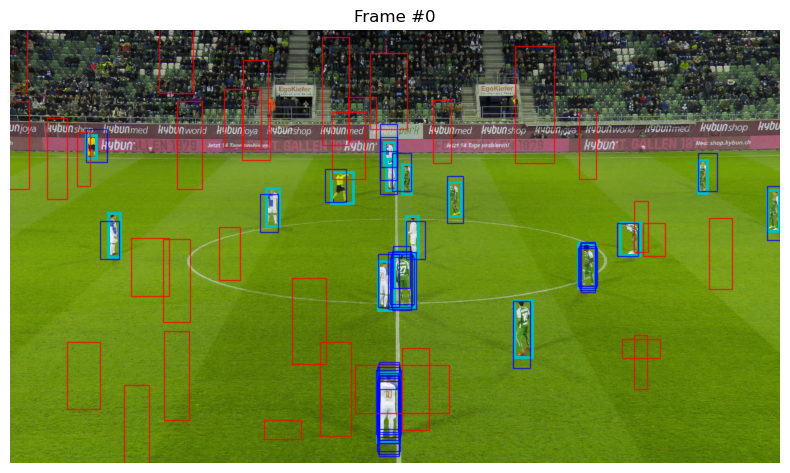

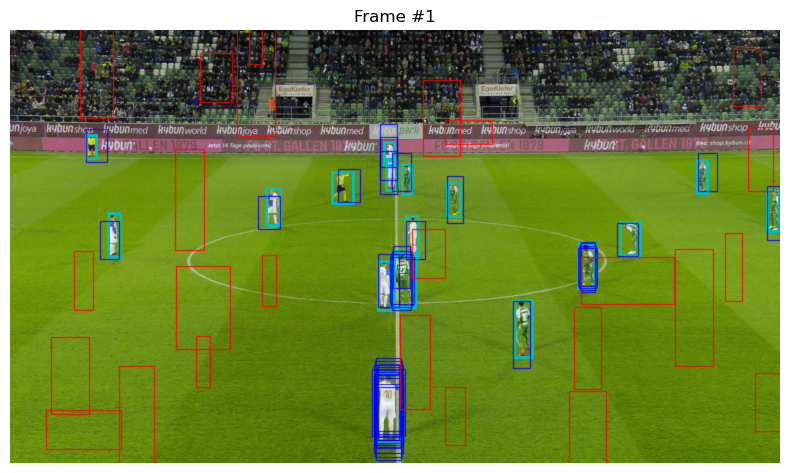

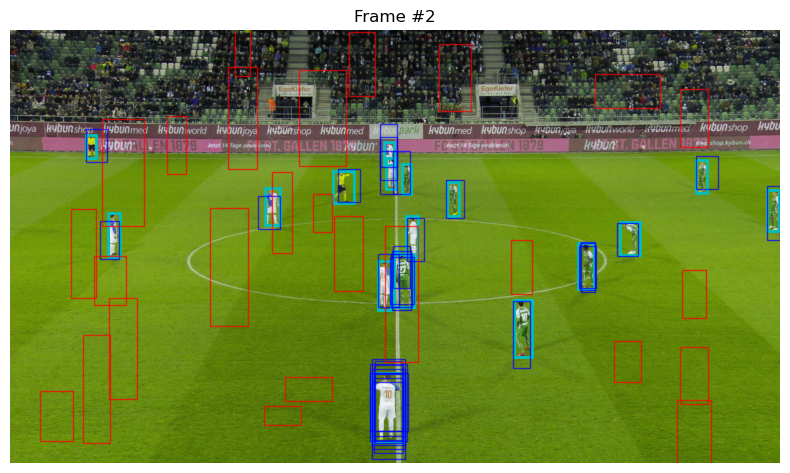

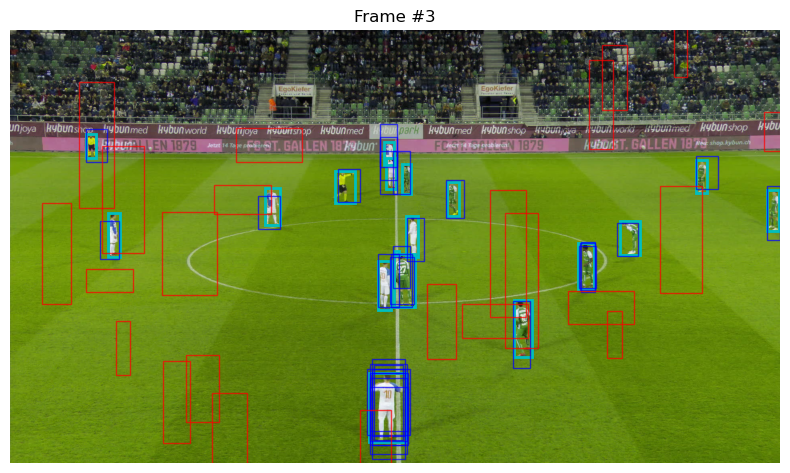

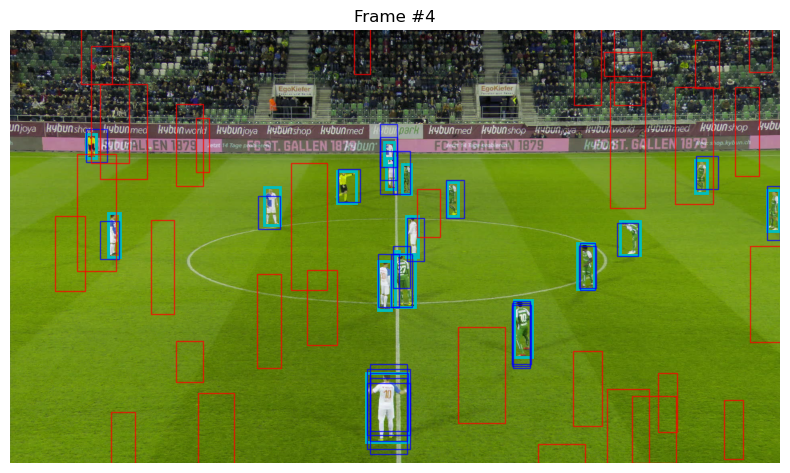

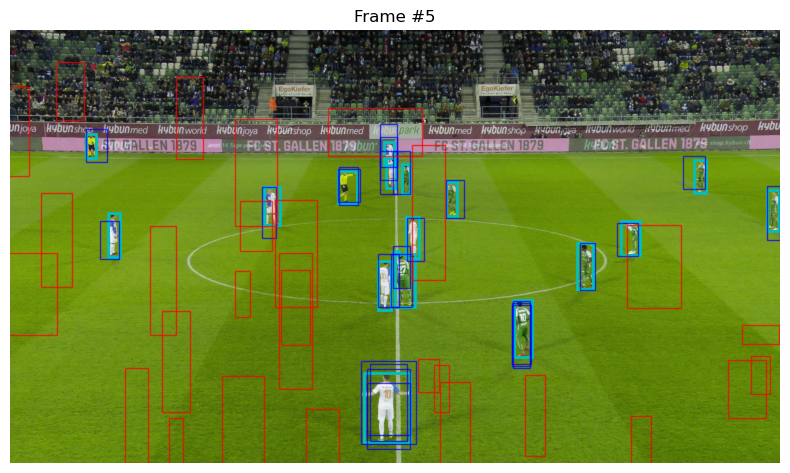

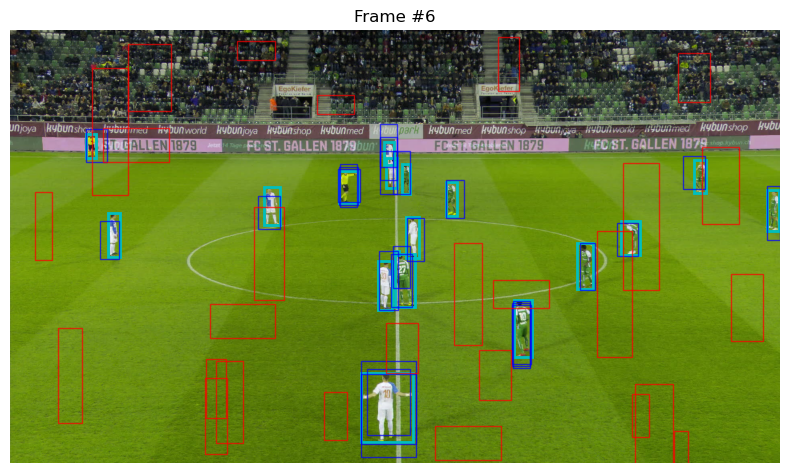

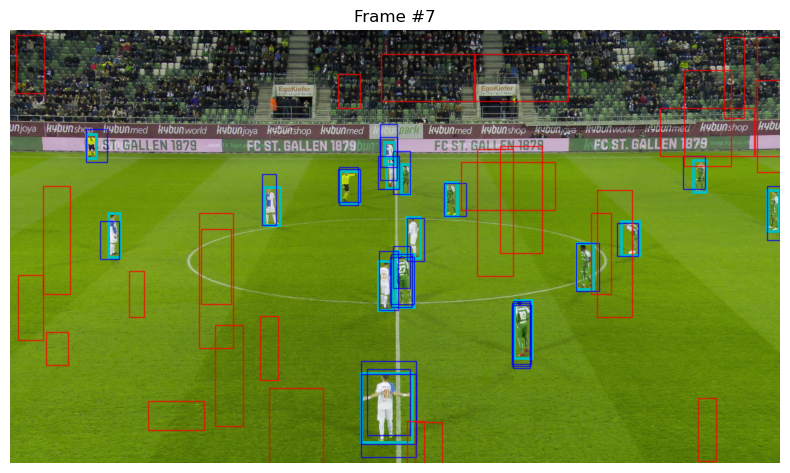

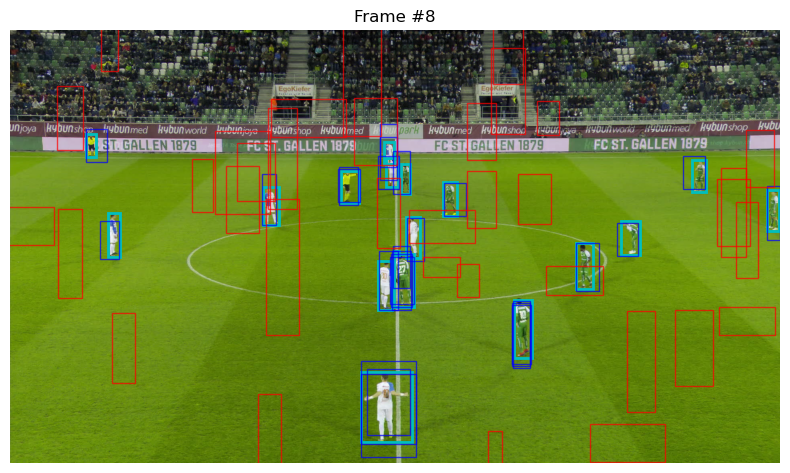

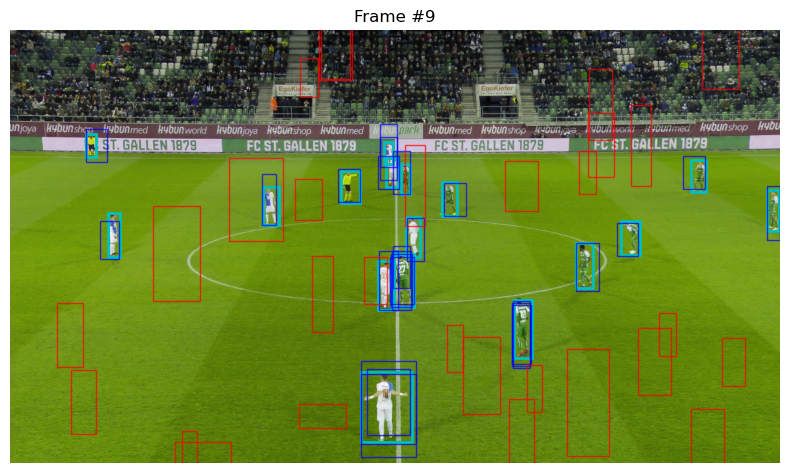

In [6]:
# experiments/exp4_ious_with_dataloader.py
import os
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from data_loader import get_dataloader


# 1) Setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)
seq_root = "../soccernet_data/tracking/train/SNMOT-060"

# We’ll grab just the first 3 frames for plotting
batch_size  = 10
num_workers = 0

# 2) DataLoader (load raw pixel tensors; we’ll normalize later for the feature‐extractor)
to_tensor = T.ToTensor()
loader = get_dataloader(
    seq_root,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    transforms=to_tensor
)

# Pull one batch
images, targets = next(iter(loader))
# images: List[ Tensor[C,H,W] ], targets: List[{"boxes":Tensor[N,4],"labels":Tensor[N]}]

# 3) Collect original sizes
orig_sizes = [(img.shape[1], img.shape[2]) for img in images]  # (H, W)

# 4) Run through your feature extractor
feat_ext = InceptionFeatureExtractor().to(device).eval()
normalize = T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

with torch.no_grad():
    feats = []
    for img in images:
        x = normalize(img).unsqueeze(0).to(device)        # [1,3,H,W]
        f = feat_ext(x)                                   # [1,C,fH,fW]
        feats.append(f)
# assume all feats same spatial size
fH, fW = feats[0].shape[2], feats[0].shape[3]
B = batch_size

# 5) Stack features into [B,C,fH,fW]
feats = torch.cat(feats, dim=0)  # [B,C,fH,fW]

# 6) Generate anchors
h_orig, w_orig = orig_sizes[0]
down_h, down_w = h_orig / fH, w_orig / fW
scales        = [2,2.5,3,3.5,4,5]
aspect_ratios = [0.5,1.5,2.0,2.5,3,3.5,4]
base_anchors  = generate_base_anchors(scales, aspect_ratios, down_h, down_w)
anchors_flat  = generate_anchor_boxes((fH,fW), base_anchors, down_h, down_w)
A = len(scales)*len(aspect_ratios)

anc = torch.from_numpy(anchors_flat).float().view(fH, fW, A, 4)
anc_batch = anc.unsqueeze(0).repeat(B,1,1,1,1)  # [B,fH,fW,A,4]

# 7) Prep GT tensors
gt_boxes_all = torch.stack([t["boxes"] for t in targets], dim=0)  # [B,N,4]
gt_classes   = torch.stack([t["labels"] for t in targets], dim=0) # [B,N]

# 8) Match to get positives / negatives
pos_thresh, neg_thresh = 0.7, 0.3
(pos_inds, neg_inds, ious, offs, cls_pos,
 pos_coords, neg_coords, _sep) = get_req_anchors(
    anc_batch, gt_boxes_all, gt_classes,
    pos_thresh=pos_thresh, neg_thresh=neg_thresh
)

# 9) Visualize exactly as before
M = fH * fW * A
pos_batch = pos_inds // M
neg_batch = neg_inds // M

for b in range(B):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    # show image in [0,1]
    img = images[b].permute(1,2,0).cpu().numpy()
    ax.imshow(img)
    ax.set_title(f"Frame #{b}")
    ax.axis("off")

    # GT boxes in cyan
    for box in gt_boxes_all[b]:
        if (box<0).any(): continue
        y0,x0,y1,x1 = box.tolist()
        ax.add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                       edgecolor='c', facecolor='none', lw=2))

    # Positives in blue
    sel = (pos_batch==b).nonzero(as_tuple=False).squeeze(-1)
    for i in sel:
        y0,x0,y1,x1 = pos_coords[i].tolist()
        ax.add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                       edgecolor='b', facecolor='none', lw=1, alpha=0.7))

    # Negatives in red
    sel = (neg_batch==b).nonzero(as_tuple=False).squeeze(-1)
    for i in sel:
        y0,x0,y1,x1 = neg_coords[i].tolist()
        ax.add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                       edgecolor='r', facecolor='none', lw=1, alpha=0.7))

    plt.tight_layout()
    plt.show()